# Rethinking_L

This notebook experiments with fitting the time till coalescence for panmictic and structured population histories. IT will try and model the time till coalescence under different scenarios (panmicitc or structured) with changing population size. It then fits this function when time is discretised. It seems like things fit the data quite well. 

In [300]:
# dependencies

import os
from datetime import datetime
import argparse
import numpy as np
import pdb
import math#
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np
import msprime

# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

def get_coal_data(sim,bin_length):
    tmrca_data = [] # first tuple is index, second tuple is sequence interval, third tuple is tMRCA
    ind = 0 #index for binning
    for tree in sim.trees():
        tmrca_data.append((tree.index,tree.interval[1],tree.time(tree.parent(0))))
        ind = math.floor(tree.interval[1]/bin_length)
    return tmrca_data

def round_bin_coal_data(seq_length,tmrca_data,bin_length):
    coal_times = np.zeros(shape=(int(seq_length/bin_length))) # create empty array which will store the binned coalescent times
    ind = 0 #index for binning
    for i in range(0,len(tmrca_data)):
        coal_times[ind:math.floor(tmrca_data[i][1]/bin_length)] = tmrca_data[i][2]
        ind = math.floor(tmrca_data[i][1]/bin_length)
    return coal_times

def round_coal_times(coal_times,T_scaled_np,N_T):
    # coal_times are the (exact) coalescent times along a sequence, as given by ms prime
    # T_scaled_np are the scaled time intervals (in a np aray)
    # N_T is the number of hidden states
    coal_times_intervals = [] 
    for i in range(0,len(coal_times)):
        diff = coal_times[i] - T_scaled_np
        diff_pos = diff[diff >0]
        where = np.argmin(diff_pos) # find closest interval
        if where == N_T: #TODO find a better fix for this. Have extended T to include upper interval
            where = where - 1
        coal_times_intervals.append(where) 
    return coal_times_intervals

def num_occcurences(array,time_intervals):
    counts = np.zeros(shape=len(time_intervals))
    for i in range(len(array)):
        counts[array[i]] += 1
    return counts

def get_counts_freq(sim,time_intervals,bin_length):
    # this function returns the observed pdf of T2 (f_T2(t))

    # get true coalescent data
    tmrca_data = get_coal_data(sim, bin_length) 

    # round this data into segments of size args.bin_length 
    coal_times = round_bin_coal_data(sim.sequence_length,tmrca_data, bin_length) # partition coalescent data into bins  


    # round coalescence time into interval
    coal_times_intervals = np.array(round_coal_times(coal_times,time_intervals,N_T=len(time_intervals))) # round binned coalescent times into their respected interval

    # count number of occurunces in each interval
    counts = num_occcurences(coal_times_intervals,time_intervals)

    # get frequency of these (divide by sum). This is the pdf (=f_T2(t))
    counts_freq = counts / counts.sum()
    return counts_freq

# define history
def psc(T_1,T_2,alpha,seq_length):
    N_0 = 1e+04 # diploid population size
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=N_0, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_0*alpha),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

# define history
def panmictic_const(seq_length):
    N_0 = 1e+04 # diploid population size
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=N_0, growth_rate=0),
    ]
    demographic_events = []
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

def split(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

def split_withpsc(N,mig_prop,T_1,T_2,alpha,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.PopulationParametersChange(time=T_1, initial_size=N*alpha),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1),
        msprime.PopulationParametersChange(time=T_2, initial_size=N)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

def split_withpsc2(N,mig_prop,T_1,T_2,alpha1,alpha2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=0, initial_size=N*alpha1),
        msprime.PopulationParametersChange(time=T_1, initial_size=N),        
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.PopulationParametersChange(time=T_1, initial_size=N*alpha2),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1),
        msprime.PopulationParametersChange(time=T_2, initial_size=N)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

def split_withpsc2a(N,mig_prop,T_1,T_2,alpha1,alpha1a,alpha2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=0, initial_size=N*alpha1),
        msprime.PopulationParametersChange(time=T_1, initial_size=N),        
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.PopulationParametersChange(time=T_1, initial_size=N*alpha2),
        msprime.PopulationParametersChange(time=T_1a, initial_size=N*alpha1a),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1),
        msprime.PopulationParametersChange(time=T_2, initial_size=N)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [301]:
min_time = 0
max_time = 3e+05
spacing = 1000
bin_length = 100
seq_length = 150e+06
time_intervals = np.arange(min_time,max_time,spacing)

# scaling
scaling = 250*len(time_intervals)*(bin_length/seq_length)

### Constant pop size, panmixia

In [3]:
# run simulation
seq_length = 150e+06


print("Running simulation")
sim0 = panmictic_const(seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


In [9]:
f_obs0 = get_counts_freq(sim0,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs0 = [sum(f_obs0[0:t]) for t in range(len(f_obs0))] # this returns the CDF of T2 ( F_T2(t) )
G_obs0 = 1 - np.array(F_obs0)
iCR_obs0 = [spacing*(1-F_obs0[i])/(2*f_obs0[i]) for i in range(len(f_obs0)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


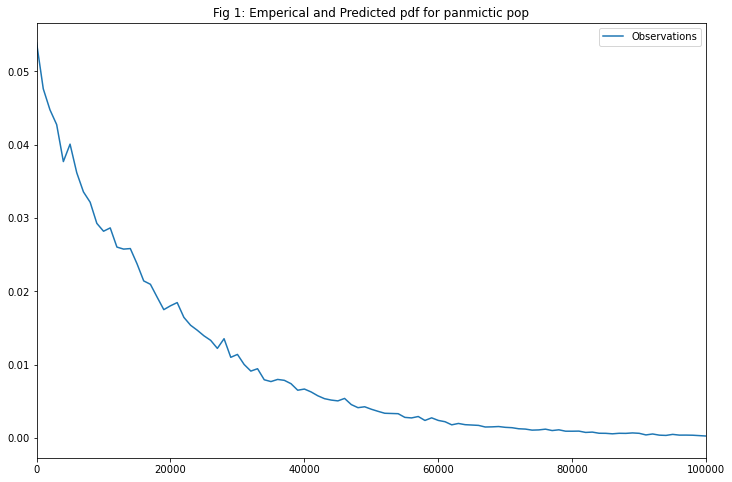

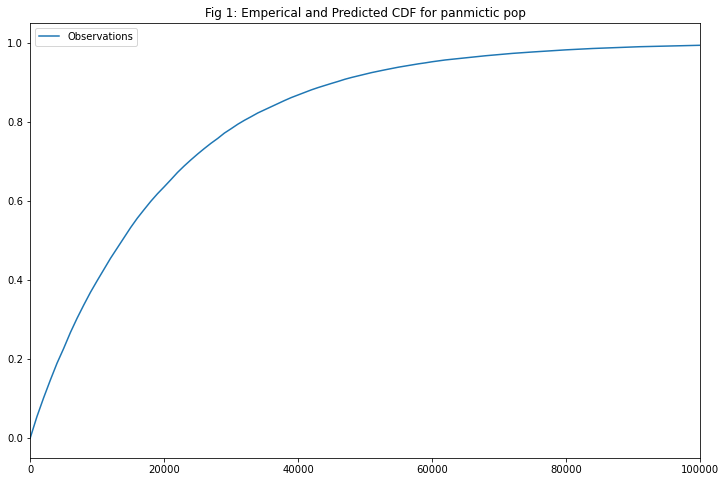

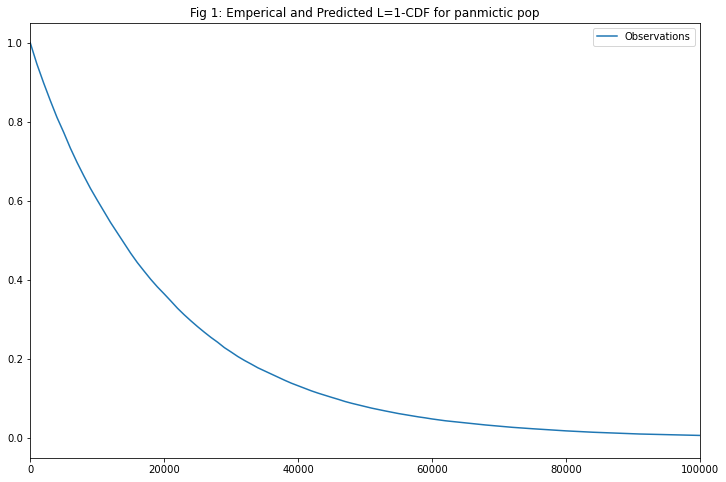

In [12]:
line_obs = plt.plot(time_intervals,f_obs0,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,F_obs0,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,G_obs0,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

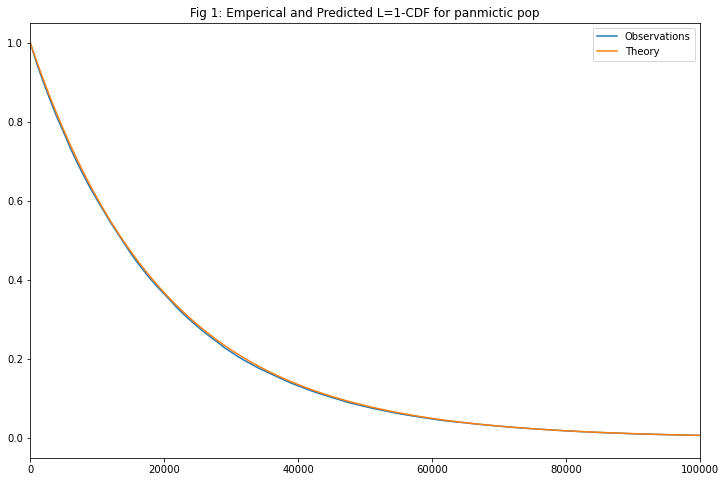

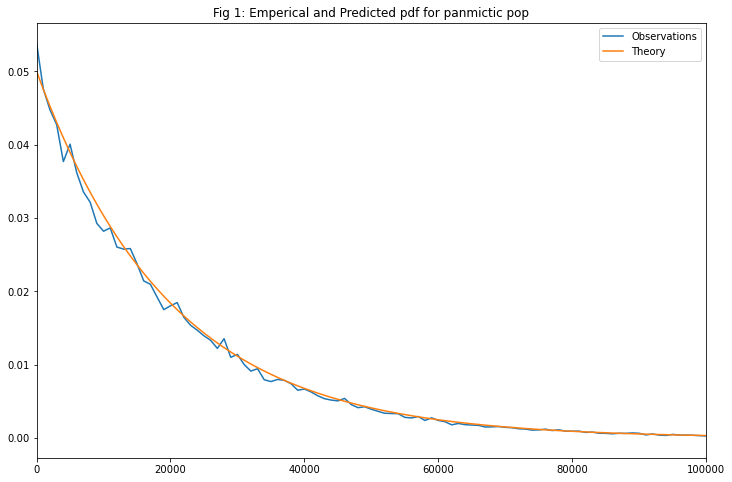

In [14]:
def G(x,N):
    x = x/(2*N)
    G = np.exp(-x)
    return G

def f(x,N):
    f = G(x,N)*scaling
    return f

N=10000
line_obs = plt.plot(time_intervals,G_obs0,label="Observations")
line_theory = plt.plot(time_intervals,G(time_intervals,N),label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,f_obs0,label="Observations")
line_theory = plt.plot(time_intervals,f(time_intervals,N),label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


### Changing pop size, panmixia

In [19]:
# run simulation
seq_length = 150e+06
T_1 = 20000
T_2 = 40000
alpha = 2

print("Running simulation")
sim1 = psc(T_1,T_2,alpha,seq_length)
print("Simulation finished")


Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000.0 
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 40000.0
   - Population parameter change for -1: initial_size -> 10000.0 
Epoch: 40000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


In [20]:
f_obs1 = get_counts_freq(sim1,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs1 = [sum(f_obs1[0:t]) for t in range(len(f_obs1))] # this returns the CDF of T2 ( F_T2(t) )
G_obs1 = 1 - np.array(F_obs1)
iCR_obs1 = [spacing*(1-F_obs1[i])/(2*f_obs1[i]) for i in range(len(f_obs1)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


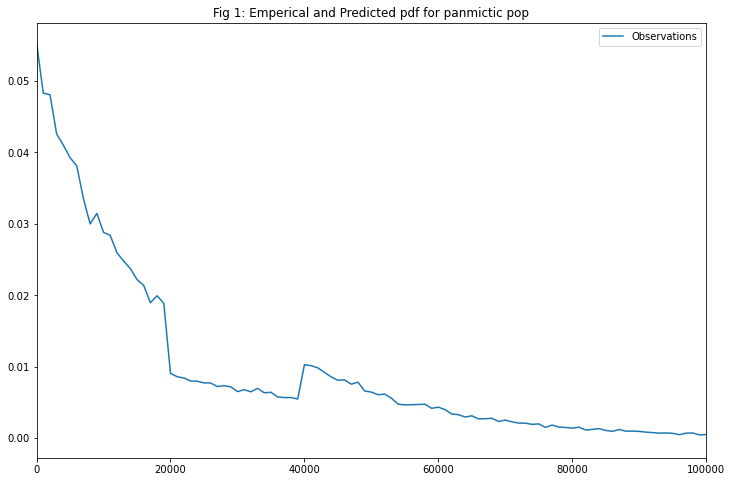

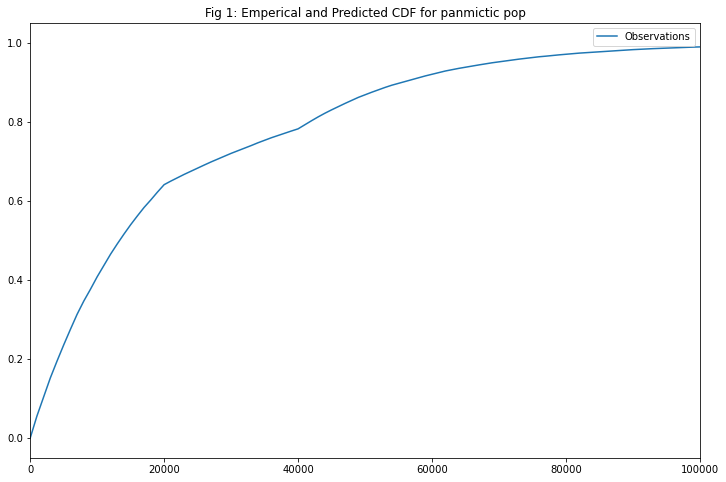

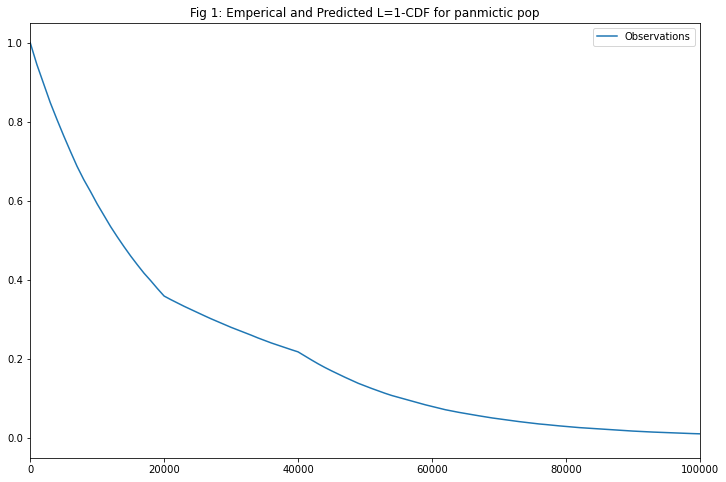

In [21]:
line_obs = plt.plot(time_intervals,f_obs1,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,F_obs1,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,G_obs1,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

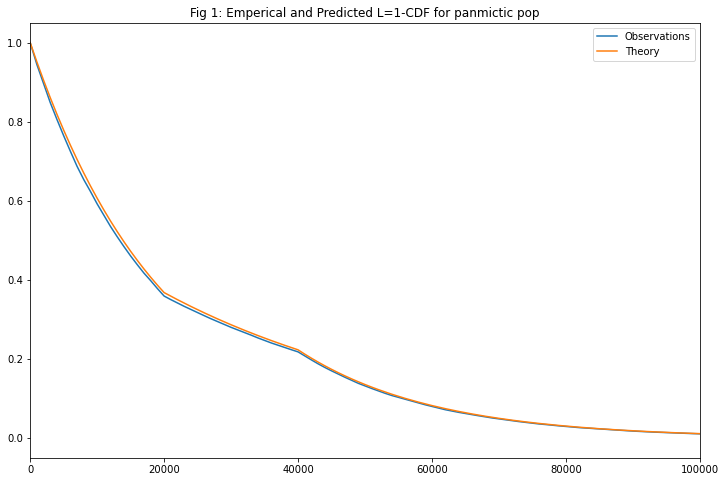

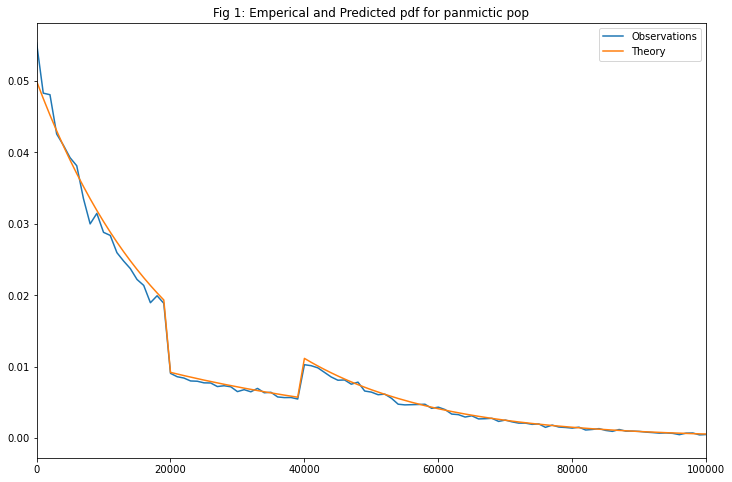

In [34]:
def G(x,N,T_1,T_2):
    if x < T_1:
        x = x/(2*N)
        G = np.exp(-x)
    elif x >= T_1 and x < T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1)*np.exp(-0.5*(x-T_1))
    elif x >= T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1)*np.exp(-0.5*(T_2-T_1))*np.exp(-(x-T_2))
    return G

def f(x,N,T_1,T_2,alpha):
    if x < T_1 or (x>=T_2):    
        f = G(x,N,T_1,T_2)*scaling
    elif x >= T_1 and x < T_2:
        f = (1/alpha)*G(x,N,T_1,T_2)*scaling
    return f

G_theory = [G(i,N,T_1,T_2) for i in time_intervals]
f_theory = [f(i,N,T_1,T_2,alpha) for i in time_intervals]
N=10000
line_obs = plt.plot(time_intervals,G_obs1,label="Observations")
line_theory = plt.plot(time_intervals,G_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,f_obs1,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


### Population structure (split)

In [13]:
N = 10000
mig_prop = 0.2
T_1 = 20000
T_2 = 40000
seq_length = 150e+06

sim2 = split(N,mig_prop,T_1,T_2,seq_length)

N is 10000
mig_prop is 0.2
t_1 is 20000 and t_2 is 40000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 40000.0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
       

In [14]:
f_obs2 = get_counts_freq(sim2,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs2 = [sum(f_obs2[0:t]) for t in range(len(f_obs2))] # this returns the CDF of T2 ( F_T2(t) )
G_obs2 = 1 - np.array(F_obs2)
iCR_obs2 = [spacing*(1-F_obs2[i])/(2*f_obs2[i]) for i in range(len(f_obs2)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


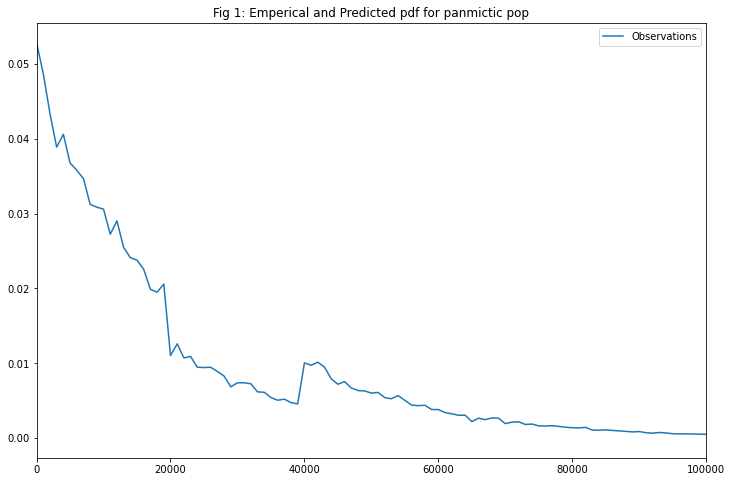

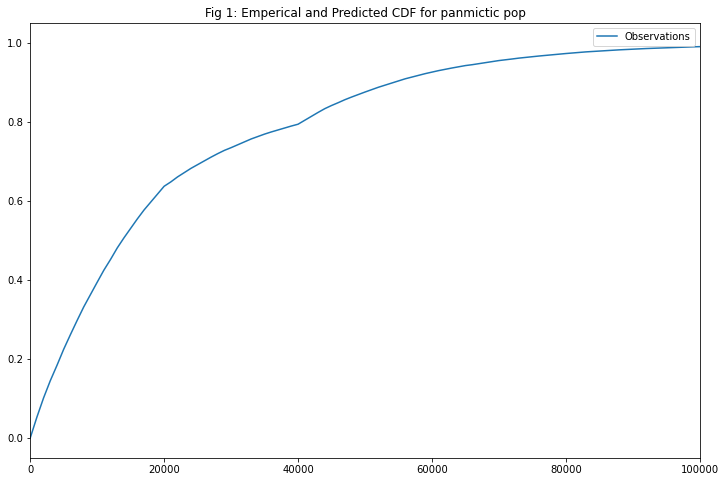

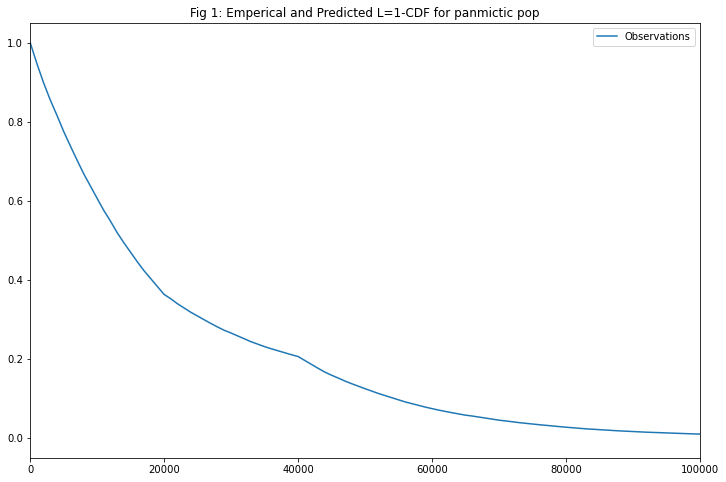

In [15]:
line_obs = plt.plot(time_intervals,f_obs2,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,F_obs2,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,G_obs2,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

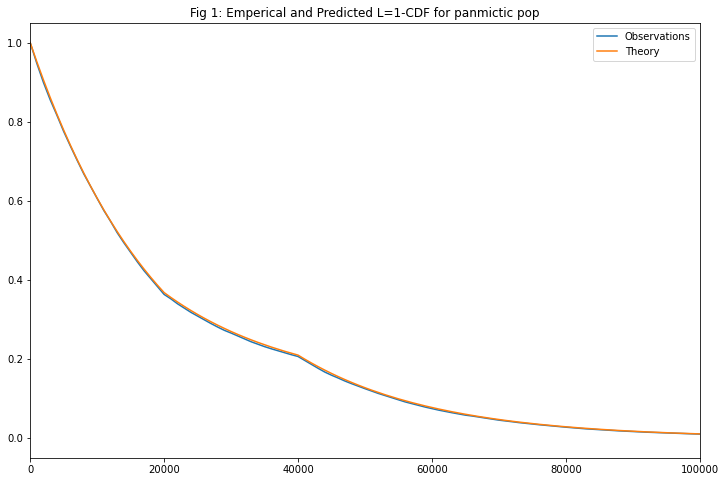

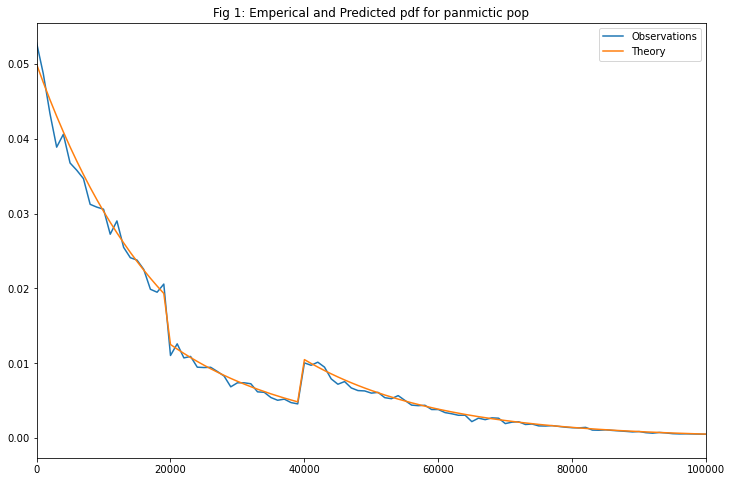

In [16]:
def G(x,N,T_1,T_2,gamma):
    if x < T_1:
        x = x/(2*N)
        G = np.exp(-x)
    elif x >= T_1 and x < T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(x-T_1))) + ((1-gamma)**2)*(np.exp(-(x-T_1))))
    elif x >= T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(T_2-T_1))) + ((1-gamma)**2)*(np.exp(-(T_2-T_1))))*np.exp(-(x-T_2))
    return G

def f(x,N,T_1,T_2,gamma):
    if x < T_1 or (x>=T_2):    
        f = G(x,N,T_1,T_2,gamma)*scaling
    elif x >= T_1 and x < T_2:
        sigma = (1-gamma)**2 + gamma**2
        f = G(T_1,N,T_1,T_2,gamma)*sigma*np.exp(-(x-T_1)/(2*N))*scaling
    return f

G_theory = [G(i,N,T_1,T_2,mig_prop) for i in time_intervals]
f_theory = [f(i,N,T_1,T_2,mig_prop) for i in time_intervals]
N=10000
line_obs = plt.plot(time_intervals,G_obs2,label="Observations")
line_theory = plt.plot(time_intervals,G_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,f_obs2,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


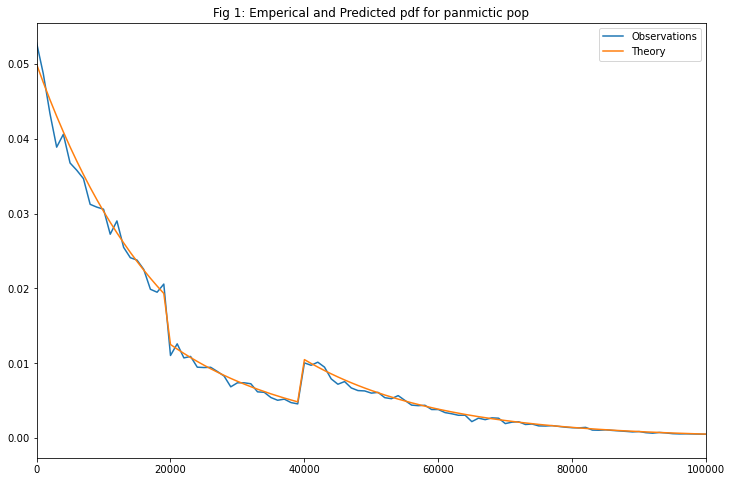

In [304]:
def L_simple(time1,time2,alpha):
    L = np.exp(-(time2 - time1)/alpha)
    return L


def f(x,N,T_1,T_2,gamma,alpha1,alpha2):
    if x < T_1:
        x = x/(2*N)
        f = (1/alpha1)*L_simple(0,x,alpha1)*scaling
    elif x >= T_1 and x < T_2:
        sigma = (1-gamma)**2 + gamma**2
        T_1_ = T_1/(2*N)
        x = x/(2*N)
        f = L_simple(0,T_1_,alpha1)*L_simple(T_1_,x,alpha2)*sigma*(1/alpha2)*scaling
    elif x>=T_2:
        sigma = (1-gamma)**2 + gamma**2
        x = x/(2*N)
        T_1_ = T_1/(2*N)
        T_2_ = T_2/(2*N)
        f = L_simple(0,T_1_,alpha1)*(1-sigma+sigma*L_simple(T_1_,T_2_,alpha2))*L_simple(T_2_,x,1)*scaling
    return f

f_theory = [f(i,N,T_1,T_2,mig_prop,1,1) for i in time_intervals]

line_obs = plt.plot(time_intervals,f_obs2,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


### Population split with population size change

In [93]:
N = 10000
mig_prop = 0.2
T_1 = 20000
T_2 = 40000
alpha = 1.5
seq_length = 150e+06

sim3 = split_withpsc(N,mig_prop,T_1,T_2,alpha,seq_length)

N is 10000
mig_prop is 0.2
t_1 is 20000 and t_2 is 40000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
   - Population parameter change for -1: initial_size -> 15000.0 
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 | 1.5e+04  1.5e+04              0 |     0        0    
1 | 1.5e+04  1.5e+04              0 |     0        0    

Events @ generation 40000.0
   - Mass migration: Lineages moved w

In [94]:
f_obs3 = get_counts_freq(sim3,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs3 = [sum(f_obs3[0:t]) for t in range(len(f_obs3))] # this returns the CDF of T2 ( F_T2(t) )
G_obs3 = 1 - np.array(F_obs3)
iCR_obs3 = [spacing*(1-F_obs3[i])/(2*f_obs3[i]) for i in range(len(f_obs3)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


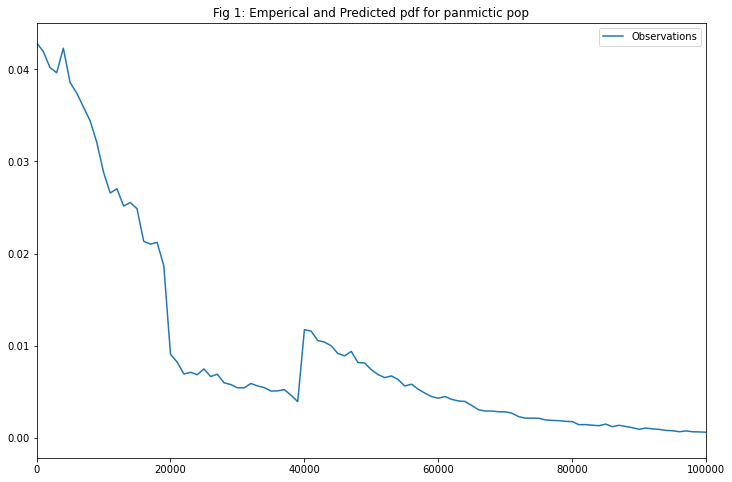

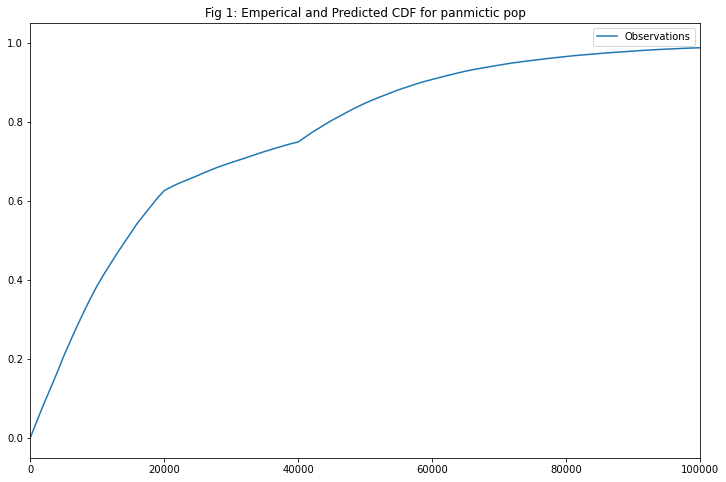

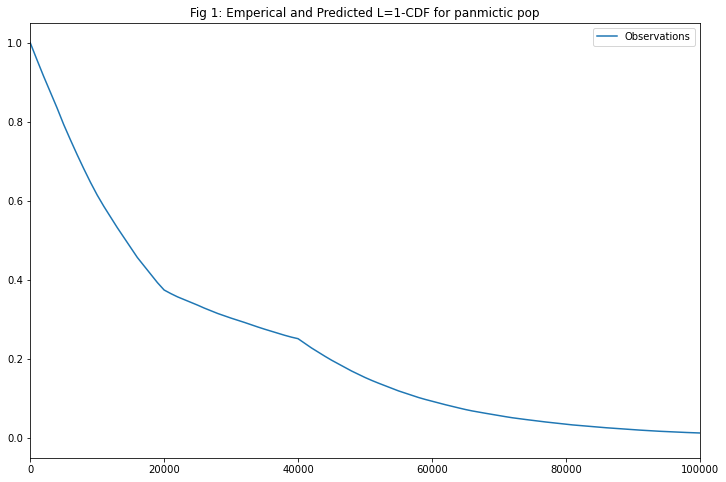

In [95]:
line_obs = plt.plot(time_intervals,f_obs3,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,F_obs3,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,G_obs3,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

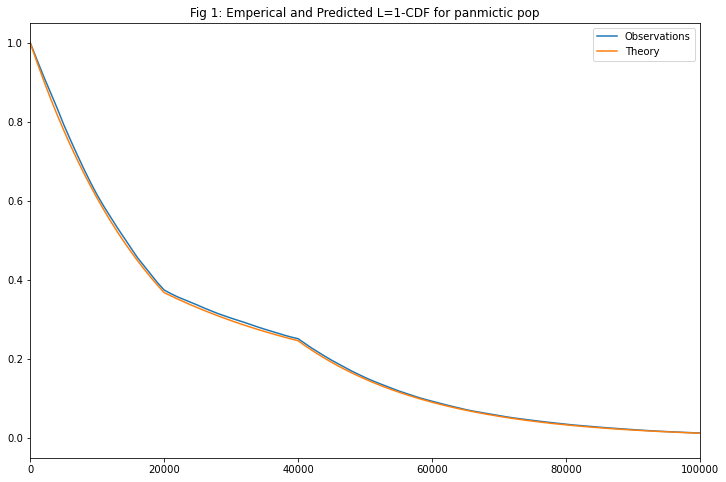

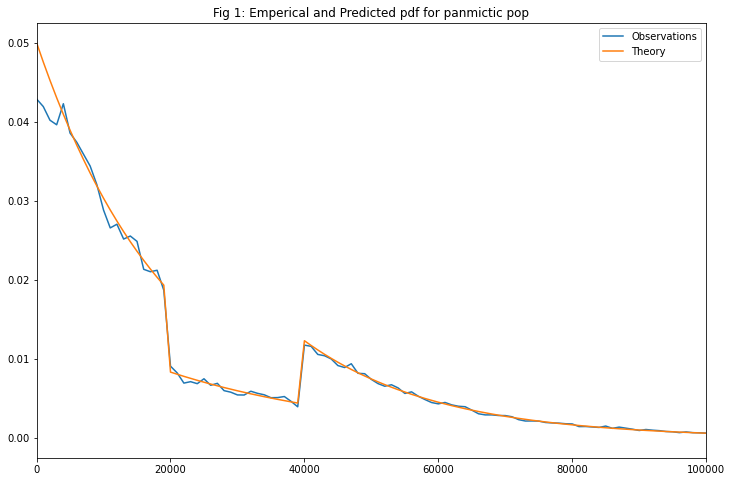

In [101]:
def G(x,N,T_1,T_2,gamma,alpha):
    if x < T_1:
        x = x/(2*N)
        G = np.exp(-x)
    elif x >= T_1 and x < T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(1/alpha)*(x-T_1))) + ((1-gamma)**2)*((np.exp(-(1/alpha)*(x-T_1)))))
    elif x >= T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(1/alpha)*(T_2-T_1))) + ((1-gamma)**2)*((np.exp(-(1/alpha)*(T_2-T_1)))))*np.exp(-(x-T_2))
    return G

def f(x,N,T_1,T_2,gamma,alpha):
    if x < T_1 or (x>=T_2):    
        f = G(x,N,T_1,T_2,gamma,alpha)*scaling
    elif x >= T_1 and x < T_2:
        sigma = (1-gamma)**2 + gamma**2
        G_ = G(T_1,N,T_1,T_2,gamma,alpha) 
        T_1 = T_1/(2*N)
        x = x/(2*N)
        f = G_*sigma*(1/alpha)*np.exp(-(1/alpha)*(x-T_1))*scaling
    return f

G_theory = [G(i,N,T_1,T_2,mig_prop,alpha) for i in time_intervals]
f_theory = [f(i,N,T_1,T_2,mig_prop,alpha) for i in time_intervals]
N=10000
line_obs = plt.plot(time_intervals,G_obs3,label="Observations")
line_theory = plt.plot(time_intervals,G_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,f_obs3,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


### Split with psc2

In [4]:
N = 10000
mig_prop = 0.2
T_1 = 20000
T_2 = 40000
alpha1 = 0.89
alpha2 = 1.5
seq_length = 150e+06

sim4 = split_withpsc2(N,mig_prop,T_1,T_2,alpha1,alpha2,seq_length)

N is 10000
mig_prop is 0.2
t_1 is 20000 and t_2 is 40000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Population parameter change for -1: initial_size -> 8900.0 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 | 8.9e+03  8.9e+03              0 |     0        0    
1 | 8.9e+03  8.9e+03              0 |     0        0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 10000 
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwar

In [5]:
f_obs4 = get_counts_freq(sim4,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs4 = [sum(f_obs4[0:t]) for t in range(len(f_obs4))] # this returns the CDF of T2 ( F_T2(t) )
G_obs4 = 1 - np.array(F_obs4)
iCR_obs4 = [spacing*(1-F_obs4[i])/(2*f_obs4[i]) for i in range(len(f_obs4)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


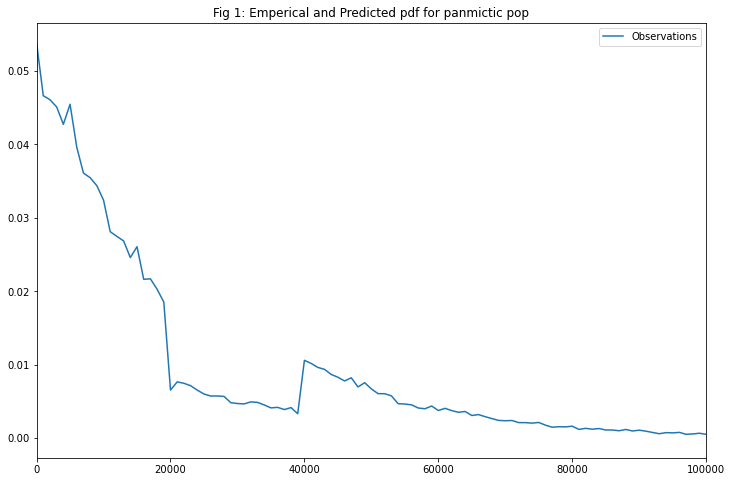

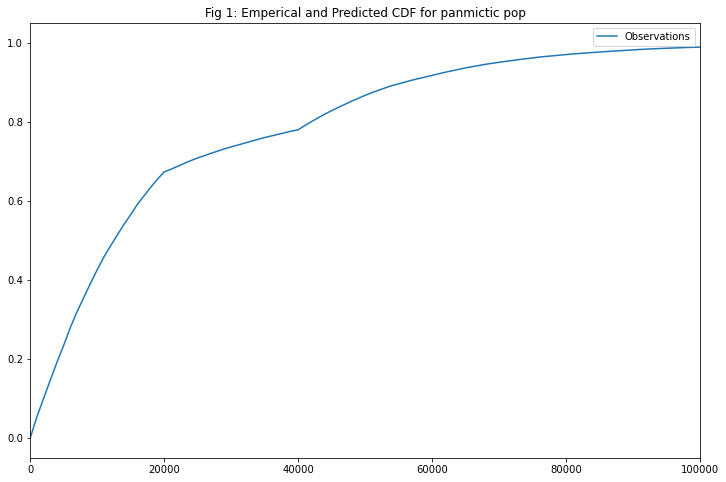

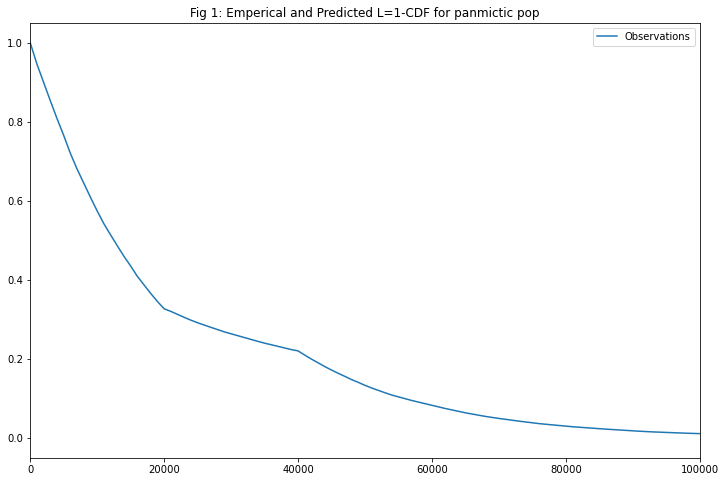

In [10]:
line_obs = plt.plot(time_intervals,f_obs4,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,F_obs4,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,G_obs4,label="Observations")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

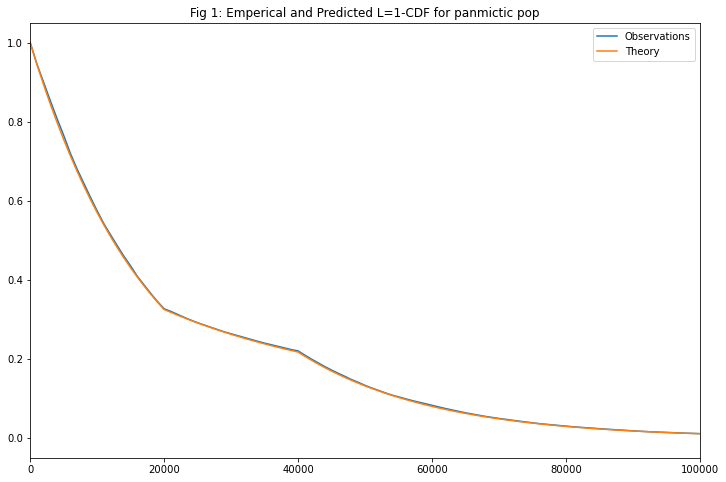

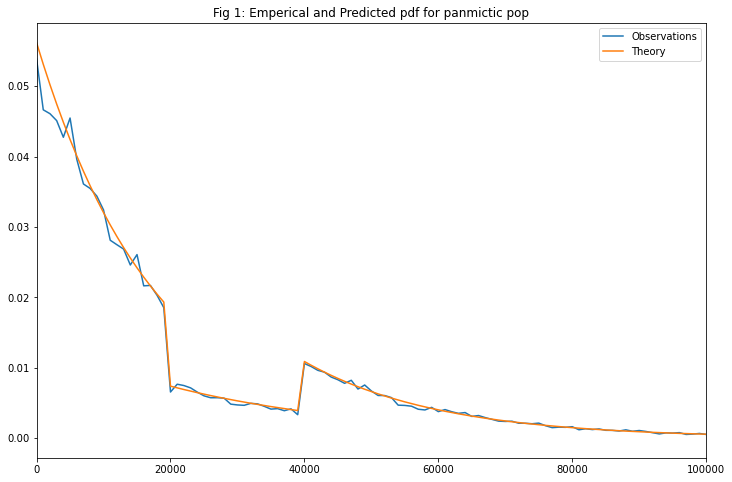

In [11]:
def G(x,N,T_1,T_2,gamma,alpha1,alpha2):
    if x < T_1:
        x = x/(2*N)
        G = np.exp(-x*(1/alpha1))
    elif x >= T_1 and x < T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1/alpha1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(1/alpha2)*(x-T_1))) + ((1-gamma)**2)*((np.exp(-(1/alpha2)*(x-T_1)))))
    elif x >= T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1/alpha1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(1/alpha2)*(T_2-T_1))) + ((1-gamma)**2)*((np.exp(-(1/alpha2)*(T_2-T_1)))))*np.exp(-(x-T_2))
    return G

def f(x,N,T_1,T_2,gamma,alpha1,alpha2):
    if x < T_1:    
        f = (1/alpha1)*G(x,N,T_1,T_2,gamma,alpha1,alpha2)*scaling
    elif x >= T_1 and x < T_2:
        sigma = (1-gamma)**2 + gamma**2
        G_ = G(T_1,N,T_1,T_2,gamma,alpha1,alpha2) 
        T_1 = T_1/(2*N)
        x = x/(2*N)
        f = G_*sigma*(1/alpha2)*np.exp(-(1/alpha2)*(x-T_1))*scaling
    elif x>=T_2:
        f = G(x,N,T_1,T_2,gamma,alpha1,alpha2)*scaling
    return f

G_theory = [G(i,N,T_1,T_2,mig_prop,alpha1,alpha2) for i in time_intervals]
f_theory = [f(i,N,T_1,T_2,mig_prop,alpha1,alpha2) for i in time_intervals]
N=10000
line_obs = plt.plot(time_intervals,G_obs4,label="Observations")
line_theory = plt.plot(time_intervals,G_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,f_obs4,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


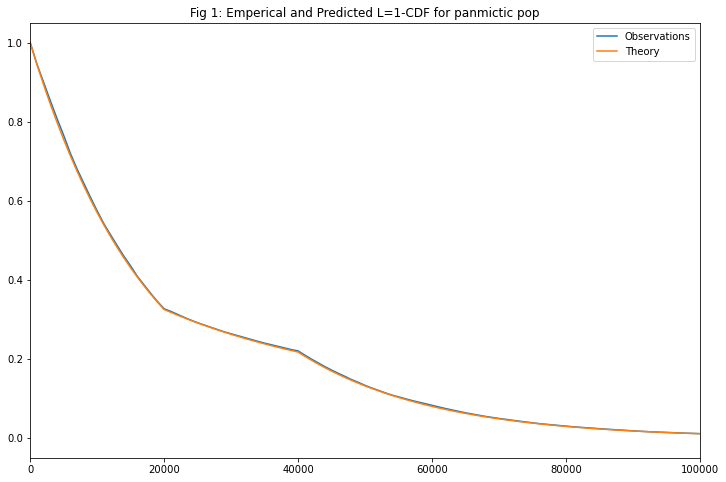

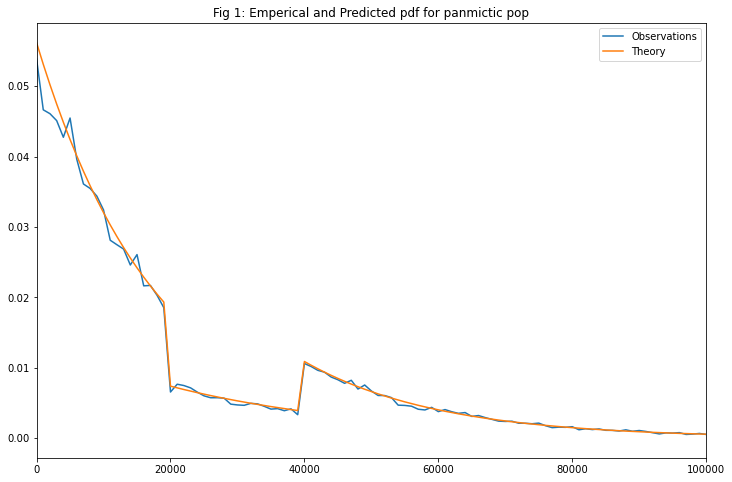

In [12]:
def G(x,N,T_1,T_2,gamma,alpha1,alpha2):
    if x < T_1:
        x = x/(2*N)
        G = np.exp(-x*(1/alpha1))
    elif x >= T_1 and x < T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1/alpha1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(1/alpha2)*(x-T_1))) + ((1-gamma)**2)*((np.exp(-(1/alpha2)*(x-T_1)))))
    elif x >= T_2:
        x = x/(2*N)
        T_1 = T_1/(2*N)
        T_2 = T_2/(2*N)
        G = np.exp(-T_1/alpha1)*( 1 - (gamma**2+((1-gamma)**2)) +  gamma**2*(np.exp(-(1/alpha2)*(T_2-T_1))) + ((1-gamma)**2)*((np.exp(-(1/alpha2)*(T_2-T_1)))))*np.exp(-(x-T_2))
    return G

def f(x,N,T_1,T_2,gamma,alpha1,alpha2):
    if x < T_1:
        x = x/(2*N)
        f = (1/alpha1)*np.exp(-x*(1/alpha1))*scaling
    elif x >= T_1 and x < T_2:
        sigma = (1-gamma)**2 + gamma**2
        T_1_ = T_1/(2*N)
        x = x/(2*N)
        f = np.exp(-T_1_*(1/alpha1))*np.exp(-(x-T_1_)/alpha2)*sigma*(1/alpha2)*scaling
    elif x>=T_2:
        sigma = (1-gamma)**2 + gamma**2
        x = x/(2*N)
        T_1_ = T_1/(2*N)
        T_2_ = T_2/(2*N)
        f = np.exp(-T_1_*(1/alpha1))*(1 - sigma + sigma*np.exp(-(T_2_-T_1_)/alpha2))*np.exp(-(x-T_2_))*scaling
    return f

G_theory = [G(i,N,T_1,T_2,mig_prop,alpha1,alpha2) for i in time_intervals]
f_theory = [f(i,N,T_1,T_2,mig_prop,alpha1,alpha2) for i in time_intervals]
N=10000
line_obs = plt.plot(time_intervals,G_obs4,label="Observations")
line_theory = plt.plot(time_intervals,G_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted L=1-CDF for panmictic pop')
plt.show()

line_obs = plt.plot(time_intervals,f_obs4,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


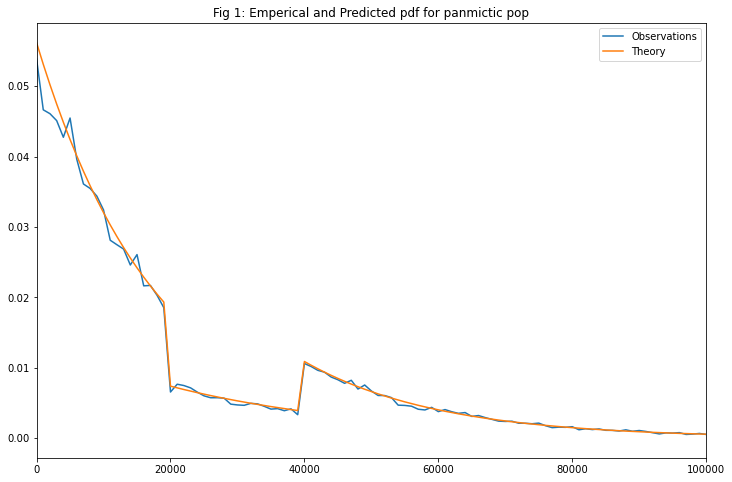

In [34]:
def L(time1,time2,alpha):
    L = np.exp(-(time2 - time1)/alpha)
    return L


def f(x,N,T_1,T_2,gamma,alpha1,alpha2):
    if x < T_1:
        x = x/(2*N)
        f = (1/alpha1)*L(0,x,alpha1)*scaling
    elif x >= T_1 and x < T_2:
        sigma = (1-gamma)**2 + gamma**2
        T_1_ = T_1/(2*N)
        x = x/(2*N)
        f = L(0,T_1_,alpha1)*L(T_1_,x,alpha2)*sigma*(1/alpha2)*scaling
    elif x>=T_2:
        sigma = (1-gamma)**2 + gamma**2
        x = x/(2*N)
        T_1_ = T_1/(2*N)
        T_2_ = T_2/(2*N)
        f = L(0,T_1_,alpha1)*(1-sigma+sigma*L(T_1_,T_2_,alpha2))*L(T_2_,x,1)*scaling
    return f

f_theory = [f(i,N,T_1,T_2,mig_prop,alpha1,alpha2) for i in time_intervals]

line_obs = plt.plot(time_intervals,f_obs4,label="Observations")
line_theory = plt.plot(time_intervals,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()


#### Now try with time intervals

In [197]:
# define time intervals

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0


In [296]:
# find time interval boundarys

minlower=np.argmin(abs(T_scaled_np - 20000))
print(f'min lower interval is {T_scaled_np[minlower]}, minlower is {minlower}')
minupper=np.argmin(abs(T_scaled_np - 40000))
print(f'min upper interval is {T_scaled_np[minupper]}, minupper is {minupper}')

min lower interval is 19711.381766577215, minlower is 32
min upper interval is 41415.65339447675, minupper is 39


In [297]:
# define lambda and gamma arrays 

lambda_array = np.array([1 for i in range(0,N_T)],np.float)
lambda_array[0:minlower]=0.89
lambda_array[minlower:minupper] = 1.5
print(f'lambda array is {lambda_array}')


gamma_array = np.array([1 for i in range(0,N_T)],np.float)
gamma_array[minlower:minupper] = 0.2
print(f'gamma array is {gamma_array}')

lambda array is [0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.89 0.89 0.89 0.89 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.  ]
gamma array is [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2
 0.2 0.2 0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


In [298]:
# define L 

def L_old(time1,ind1,time2,ind2):
    """
    L is the probability of not coalescing between time1 and time2)
    time is in coalescent units
    There are 4 possibilities:
    time1 and time2 continuous
    time1 continuous time2 discrete
    time2 continuous time1 discrete
    time1 and time2 discrete"""
    # sum
    if ind1 == ind2:
        L = math.exp(-(time2 - time1)/lambda_array[ind1])
    else:
        sum = 0
        for i in range(ind1+1,ind2):
            sum = sum + delta(i,T_np)/lambda_array[i]
        L = math.exp(-(T[ind1+1] - time1)/lambda_array[ind1] - sum - (time2 - T[ind2])/lambda_array[ind2])
    return L

# flagqqq

def L(time1,ind1,time2,ind2):
    # this is a newer L, works jsut as well
    # go from 0 to time2, then 0 to time1, and divide
    """
    L is the probability of not coalescing between time1 and time2)
    time is in coalescent units
    There are 4 possibilities:
    time1 and time2 continuous
    time1 continuous time2 discrete
    time2 continuous time1 discrete
    time1 and time2 discrete"""
    
    ind = ind1
    time = time1
    if ind == 0:
        L_lower = np.exp(-time/lambda_array[ind])
    else:
        sum = 0
        for i in range(0,ind):
            sum = sum + delta(i,T_np)/lambda_array[i]
        L_lower = np.exp(-sum - (time - T[ind])/lambda_array[ind])

    ind = ind2
    time = time2
    if ind == 0:
        L_upper = np.exp(-time/lambda_array[ind])
    else:
        sum = 0
        for i in range(0,ind):
            sum = sum + delta(i,T_np)/lambda_array[i]
        L_upper = np.exp(-sum - (time - T[ind])/lambda_array[ind])

    L = L_upper/L_lower
    return L
        
def delta(ind,T):
    delt = T[ind+1]-T[ind]
    return delt

def lower_higher_intervals(t1,t2,T):
    # get the index of the next lower or equal time intervals for t1 and t2
    ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
    if T[ind1] > t1:
        ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
    ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
    if T[ind2] > t2:
        ind2 = ind2 - 1
    if ind2 == N_T:
        # if ind2 is the last time interval, remove 1 otherwise will crash
        ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
    return ind1, ind2


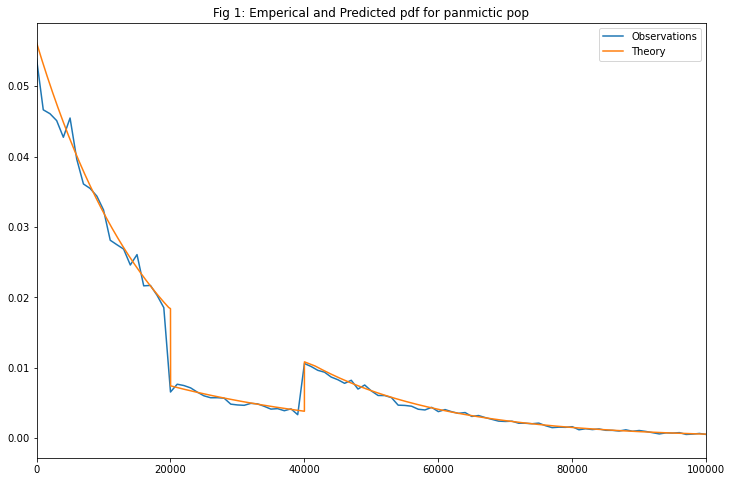

In [305]:
def f(x,N,T_1,T_2,T_np):
#     pdb.set_trace()
    x = x/(2*N)
    T_1_ = T_1/(2*N)
    T_2_ = T_2/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    if x < T_1_:
        f = (1/lambda_array[ind1])*L(0,ind1,x,ind2)*scaling
    elif x >= T_1_ and x < T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
        sigma = (1-gamma_array[ind2])**2 + gamma_array[ind2]**2
        f = L(0,0,T_1_,minlower)*L(T_1_,minlower,x,ind2)*sigma*(1/lambda_array[ind2])*scaling
    elif x>=T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
#         pdb.set_trace()
#         print('ind1 and ind2 are {}'.format([ind1,ind2]))
        sigma = (1-gamma_array[34])**2 + gamma_array[34]**2
        f = L(0,0,T_1_,minlower)*(1-sigma+sigma*L(T_1_,minlower,T_2_,minupper))*L(T_2_,minupper,x,ind2)*scaling
        #         f = 0.01*L(T_2_,minupper,x,ind2)
    return f

all_time = [i for i in range(0,100000)]
f_theory = [f(i,N,T_1,T_2,T_np) for i in all_time]

line_obs = plt.plot(time_intervals,f_obs4,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

### Split with psc2 with changes that align with T_np

In [212]:
N = 10000
mig_prop = 0.2
T_1 = T_np[25]*2*N_0
T_2 = T_np[35]*2*N_0
alpha1 = 0.89
alpha2 = 1.5
seq_length = 150e+06

sim4a = split_withpsc2(N,mig_prop,T_1,T_2,alpha1,alpha2,seq_length)

N is 10000
mig_prop is 0.2
t_1 is 9381.442505494031 and t_2 is 27096.22767576434
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Population parameter change for -1: initial_size -> 8900.0 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 9381.442505494031 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 | 8.9e+03  8.9e+03              0 |     0        0    
1 | 8.9e+03  8.9e+03              0 |     0        0    

Events @ generation 9381.442505494031
   - Population parameter change for -1: initial_size -> 10000 
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                    

In [221]:
f_obs4a = get_counts_freq(sim4a,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs4a = [sum(f_obs4a[0:t]) for t in range(len(f_obs4a))] # this returns the CDF of T2 ( F_T2(t) )
G_obs4a = 1 - np.array(F_obs4a)
iCR_obs4a = [spacing*(1-F_obs4a[i])/(2*f_obs4a[i]) for i in range(len(f_obs4a)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [308]:
# find time interval boundarys

minlower=np.argmin(abs(T_scaled_np - T_1))
print(f'min lower interval is {T_scaled_np[minlower]}, minlower is {minlower}')
minupper=np.argmin(abs(T_scaled_np - T_2))  
print(f'min upper interval is {T_scaled_np[minupper]}, minupper is {minupper}')

min lower interval is 9381.442505494031, minlower is 25
min upper interval is 27096.22767576434, minupper is 35


In [309]:
# define lambda and gamma arrays 

lambda_array = np.array([1 for i in range(0,N_T)],np.float)
lambda_array[0:minlower]=0.89
lambda_array[minlower:minupper] = 1.5
print(f'lambda array is {lambda_array}')


gamma_array = np.array([1 for i in range(0,N_T)],np.float)
gamma_array[minlower:minupper] = 0.2
print(f'gamma array is {gamma_array}')

lambda array is [0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 1.5  1.5  1.5
 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.  ]
gamma array is [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


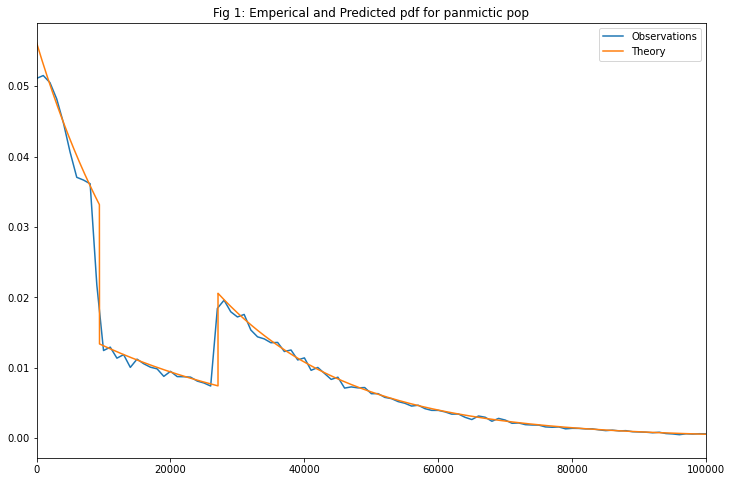

In [310]:
def f(x,N,T_1,T_2,T_np):
#     pdb.set_trace()
    x = x/(2*N)
    T_1_ = T_1/(2*N)
    T_2_ = T_2/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    if x < T_1_:
        f = (1/lambda_array[ind1])*L(0,ind1,x,ind2)*scaling
    elif x >= T_1_ and x < T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
        sigma = (1-gamma_array[ind2])**2 + gamma_array[ind2]**2
        f = L(0,0,T_1_,minlower)*L(T_1_,minlower,x,ind2)*sigma*(1/lambda_array[ind2])*scaling
    elif x>=T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
#         pdb.set_trace()
#         print('ind1 and ind2 are {}'.format([ind1,ind2]))
        sigma = (1-gamma_array[34])**2 + gamma_array[34]**2
        f = L(0,0,T_1_,minlower)*(1-sigma+sigma*L(T_1_,minlower,T_2_,minupper))*L(T_2_,minupper,x,ind2)*scaling
        #         f = 0.01*L(T_2_,minupper,x,ind2)
    return f

all_time = [i for i in range(0,100000)]
f_theory = [f(i,N,T_1,T_2,T_np) for i in all_time]

line_obs = plt.plot(time_intervals,f_obs4a,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

### Split with psc2 with changes that align with T_np with multiple lambda changes

In [430]:
N = 10000
mig_prop = 0.2
T_1 = T_np[25]*2*N_0
T_1a = T_np[30]*2*N_0
T_2 = T_np[35]*2*N_0
alpha1 = 0.89
alpha1a = 2
alpha2 = 1.5

In [243]:
N = 10000
mig_prop = 0.2
T_1 = T_np[25]*2*N_0
T_1a = T_np[30]*2*N_0
T_2 = T_np[35]*2*N_0
alpha1 = 0.89
alpha1a = 2
alpha2 = 1.5
seq_length = 150e+06

sim4b = split_withpsc2a(N,mig_prop,T_1,T_2,alpha1,alpha1a,alpha2,seq_length)

N is 10000
mig_prop is 0.2
t_1 is 9381.442505494031 and t_2 is 27096.22767576434
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Population parameter change for -1: initial_size -> 8900.0 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 9381.442505494031 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 | 8.9e+03  8.9e+03              0 |     0        0    
1 | 8.9e+03  8.9e+03              0 |     0        0    

Events @ generation 9381.442505494031
   - Population parameter change for -1: initial_size -> 10000 
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                    

In [244]:
f_obs4b = get_counts_freq(sim4b,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs4b = [sum(f_obs4b[0:t]) for t in range(len(f_obs4b))] # this returns the CDF of T2 ( F_T2(t) )
G_obs4b = 1 - np.array(F_obs4b)
iCR_obs4b = [spacing*(1-F_obs4b[i])/(2*f_obs4b[i]) for i in range(len(f_obs4a)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [431]:
# find time interval boundarys

minlower=np.argmin(abs(T_scaled_np - T_1))
print(f'min lower interval is {T_scaled_np[minlower]}, minlower is {minlower}')

minmiddle=np.argmin(abs(T_scaled_np - T_1a))
print(f'min mid interval is {T_scaled_np[minmiddle]}, minmiddle is {minmiddle}')

minupper=np.argmin(abs(T_scaled_np - T_2)) 
print(f'min upper interval is {T_scaled_np[minupper]}, minupper is {minupper}')

min lower interval is 9381.442505494031, minlower is 25
min mid interval is 15943.704151042171, minmiddle is 30
min upper interval is 27096.22767576434, minupper is 35


In [432]:
# define lambda and gamma arrays 

lambda_array = np.array([1 for i in range(0,N_T)],np.float)
lambda_array[0:minlower]=0.89
lambda_array[minlower:minmiddle]=1.5
lambda_array[minmiddle:minupper] = 2
print(f'lambda array is {lambda_array}')


gamma_array = np.array([1 for i in range(0,N_T)],np.float)
gamma_array[minlower:minupper] = 0.2
print(f'gamma array is {gamma_array}')

lambda array is [0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 1.5  1.5  1.5
 1.5  1.5  2.   2.   2.   2.   2.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.  ]
gamma array is [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


In [433]:
def f(x,N,T_1,T_2,T_np):
#     pdb.set_trace()
    x = x/(2*N)
    T_1_ = T_1/(2*N)
    T_2_ = T_2/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    if x < T_1_:
        f = (1/lambda_array[ind1])*L(0,ind1,x,ind2)*scaling
    elif x >= T_1_ and x < T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
        sigma = (1-gamma_array[ind2])**2 + gamma_array[ind2]**2
        f = L(0,0,T_1_,minlower)*L(T_1_,minlower,x,ind2)*sigma*(1/lambda_array[ind2])*scaling
    elif x>=T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
#         pdb.set_trace()
#         print('ind1 and ind2 are {}'.format([ind1,ind2]))
        sigma = (1-gamma_array[34])**2 + gamma_array[34]**2
        f = L(0,0,T_1_,minlower)*(1-sigma+sigma*L(T_1_,minlower,T_2_,minupper))*L(T_2_,minupper,x,ind2)*scaling
        #         f = 0.01*L(T_2_,minupper,x,ind2)
    return f

all_time = [i for i in range(0,100000)]
f_theory = [f(i,N,T_1,T_2,T_np) for i in all_time]

line_obs = plt.plot(time_intervals,f_obs4b,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

TypeError: L() takes 2 positional arguments but 4 were given

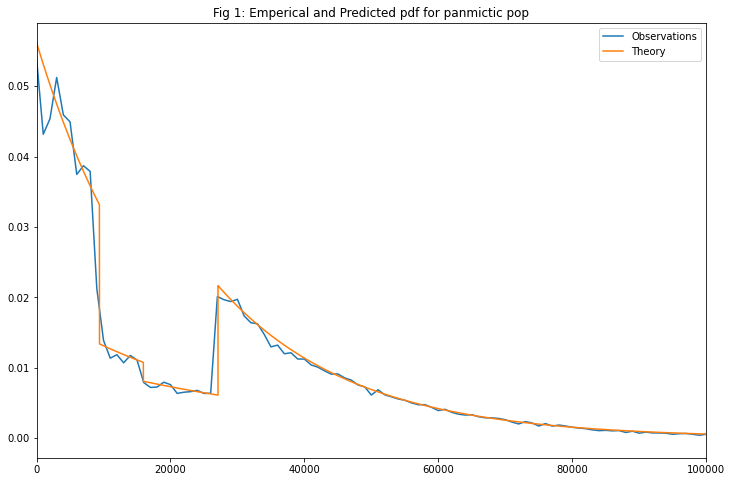

In [315]:
def f(x,N,T_1,T_2,T_np):
#     pdb.set_trace()
    x = x/(2*N)
    T_1_ = T_1/(2*N)
    T_2_ = T_2/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    if x < T_1_:
        f = (1/lambda_array[ind1])*L(0,ind1,x,ind2)*scaling
    elif x >= T_1_ and x < T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
        sigma = (1-gamma_array[ind2])**2 + gamma_array[ind2]**2
        f = L(0,0,x,ind2)*sigma*(1/lambda_array[ind2])*scaling
    elif x>=T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
#         pdb.set_trace()
#         print('ind1 and ind2 are {}'.format([ind1,ind2]))
        sigma = (1-gamma_array[34])**2 + gamma_array[34]**2
        f = L(0,0,T_1_,minlower)*(1-sigma+sigma*L(T_1_,minlower,T_2_,minupper))*L(T_2_,minupper,x,ind2)*scaling
        #         f = 0.01*L(T_2_,minupper,x,ind2)
    return f

all_time = [i for i in range(0,100000)]
f_theory = [f(i,N,T_1,T_2,T_np) for i in all_time]

line_obs = plt.plot(time_intervals,f_obs4b,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

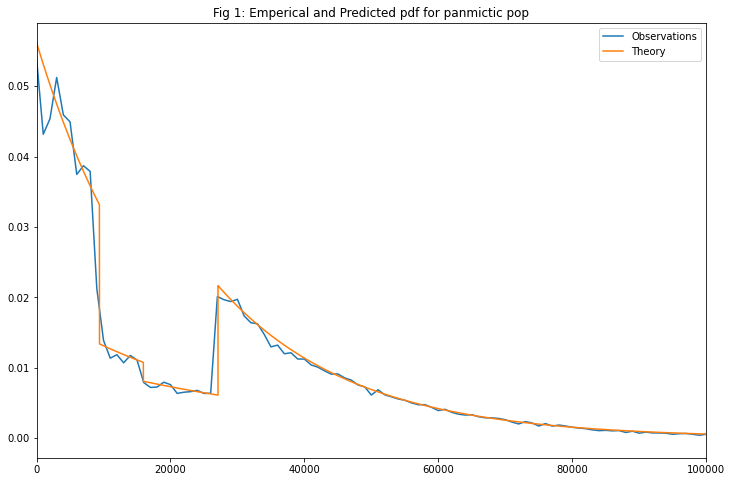

In [434]:
def f(x,N,T_1,T_2,T_np):
#     pdb.set_trace()
    x = x/(2*N)
    T_1_ = T_1/(2*N)
    T_2_ = T_2/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    if x < T_1_:
        f = (1/lambda_array[ind1])*L_new(0,ind1,x,ind2)*scaling
    elif x >= T_1_ and x < T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
        sigma = (1-gamma_array[ind2])**2 + gamma_array[ind2]**2
        f = L_new(0,0,x,ind2)*sigma*(1/lambda_array[ind2])*scaling
    elif x>=T_2_:
        ind1, ind2 = lower_higher_intervals(0,x,T_np)
#         pdb.set_trace()
#         print('ind1 and ind2 are {}'.format([ind1,ind2]))
        sigma = (1-gamma_array[34])**2 + gamma_array[34]**2
        f = L_new(0,0,T_1_,minlower)*(1-sigma+sigma*L_new(T_1_,minlower,T_2_,minupper))*L_new(T_2_,minupper,x,ind2)*scaling
        #         f = 0.01*L(T_2_,minupper,x,ind2)
    return f

all_time = [i for i in range(0,100000)]
f_theory = [f(i,N,T_1,T_2,T_np) for i in all_time]

line_obs = plt.plot(time_intervals,f_obs4b,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for panmictic pop')
plt.show()

In [435]:
L_newq = L(T_np[12]+0.007,12,T_np[37]+0.234,37)
Lq = L_old(T_np[12]+0.007,12,T_np[37]+0.234,37)
print('L_new is {}'.format(L_newq))
print('L is {}'.format(Lq))

TypeError: L() takes 2 positional arguments but 4 were given

Now try with G, which is wrapped around L

In [428]:
# def f(x,N,T_1,T_2,T_np):
# #     pdb.set_trace()
#     x = x/(2*N)
#     T_1_ = T_1/(2*N)
#     T_2_ = T_2/(2*N)
#     ind1, ind2 = lower_higher_intervals(0,x,T_np)
# #     print('ind1 and ind2 are {}'.format([ind1,ind2]))
#     if x < T_1_:
#         f = (1/lambda_array[ind1])*L_new(0,ind1,x,ind2)*scaling
#     elif x >= T_1_ and x < T_2_:
#         ind1, ind2 = lower_higher_intervals(0,x,T_np)
#         sigma = (1-gamma_array[ind2])**2 + gamma_array[ind2]**2
#         f = L_new(0,0,x,ind2)*sigma*(1/lambda_array[ind2])*scaling
#     elif x>=T_2_:
#         ind1, ind2 = lower_higher_intervals(0,x,T_np)
# #         pdb.set_trace()
# #         print('ind1 and ind2 are {}'.format([ind1,ind2]))
#         sigma = (1-gamma_array[34])**2 + gamma_array[34]**2
#         f = L_new(0,0,T_1_,minlower)*(1-sigma+sigma*L_new(T_1_,minlower,T_2_,minupper))*L_new(T_2_,minupper,x,ind2)*scaling
#         #         f = 0.01*L(T_2_,minupper,x,ind2)
#     return f

def G(time1,ind1,time2,ind2,psi_s,psi_e):
    # wrap this around L
    ind = ind1
    time = time1
    if time >= T[psi_e+1]:
        sig = sigma(psi_e)
        G_lower = L(0,0,T_np[psi_s],psi_s)*(1-sig + sig*L(T_np[psi_s],psi_s,T_np[psi_e+1],psi_e+1))*L(T_np[psi_e+1],psi_e+1,time,ind)
    else:
        G_lower = L(0,0,time,ind)

    ind = ind2
    time = time2
    if time >= T[psi_e+1]:
        sig = sigma(psi_e)
        G_upper = L(0,0,T_np[psi_s],psi_s)*(1-sig + sig*L(T_np[psi_s],psi_s,T_np[psi_e+1],psi_e+1))*L(T_np[psi_e+1],psi_e+1,time,ind)
    else:
        G_upper = L(0,0,time,ind)

    G = G_upper/G_lower
    return G


def sigma(i):
    # return sigma
    sig = gamma_array[i]**2 + (1-gamma_array[i])**2
    return sig

def psis_finder(gamma_array):
    # find the first change in gamma (psi_s) and last change in gamma (psi_e)
    # for now, assume there is only one period of structure
    psi_s = np.where(gamma_array!=1)[0][0]
    psi_e = np.where(gamma_array!=1)[0][-1]
    return psi_s, psi_e

In [380]:
gamma_array

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

In [422]:
# find time interval boundarys

minlower=np.argmin(abs(T_scaled_np - T_1))
print(f'min lower interval is {T_scaled_np[minlower]}, minlower is {minlower}')

minmiddle=np.argmin(abs(T_scaled_np - T_1a))
print(f'min mid interval is {T_scaled_np[minmiddle]}, minmiddle is {minmiddle}')

minupper=np.argmin(abs(T_scaled_np - T_2))
print(f'min upper interval is {T_scaled_np[minupper]}, minupper is {minupper}')

# define lambda and gamma arrays 

lambda_array = np.array([1 for i in range(0,N_T)],np.float)
lambda_array[0:minlower]=0.89
lambda_array[minlower:minmiddle]=1.5
lambda_array[minmiddle:minupper] = 2
print(f'lambda array is {lambda_array}')


gamma_array = np.array([1 for i in range(0,N_T)],np.float)
gamma_array[minlower:minupper] = 0.2
print(f'gamma array is {gamma_array}')

min lower interval is 9381.442505494031, minlower is 25
min mid interval is 15943.704151042171, minmiddle is 30
min upper interval is 27096.22767576434, minupper is 35
lambda array is [0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 1.5  1.5  1.5
 1.5  1.5  2.   2.   2.   2.   2.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.  ]
gamma array is [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


In [429]:
def f(x,N,T_1,T_2,T_np,psi_s,psi_e):
#     pdb.set_trace()
    x = x/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    f_ = G(0,0,x,ind2,psi_s,psi_e)*(sigma(ind2)/lambda_array[ind2])*scaling
#     if ind2 == psi_e-1:
#         pdb.set_trace()
#     elif ind2 == psi_e:
#         pdb.set_trace()
    return f_

all_time = [i for i in range(0,100000)]
psi_s, psi_e = psis_finder(gamma_array)
f_theory = [f(i,N,T_1,T_2,T_np,psi_s,psi_e) for i in all_time]


line_obs = plt.plot(time_intervals,f_obs4b,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for structured pop')
plt.show()


TypeError: L() takes 2 positional arguments but 4 were given

Niceeeeeeeeee working well

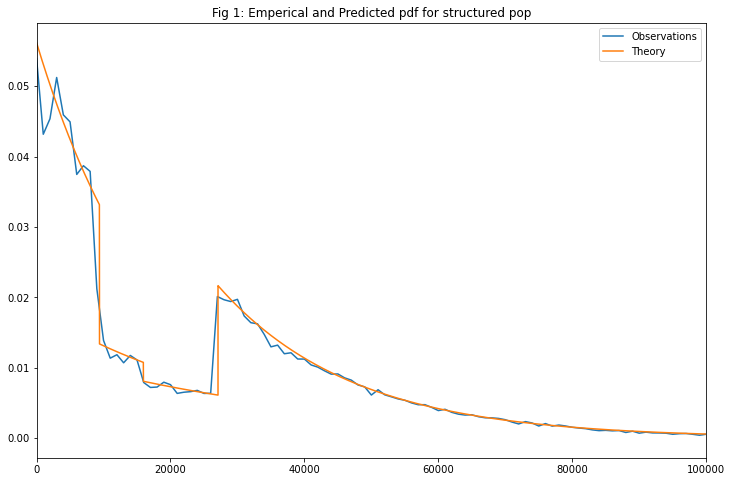

In [436]:
def L(time1,time2):
    # go from 0 to time2, then 0 to time1, and divide
    # TODO write the below double paragraph of code into one loop

    ind1, ind2 = lower_higher_intervals(time1,time2,T) # get index of intervals

    ind = ind1
    time = time1
    if ind == 0:
        L_lower = np.exp(-time/lambda_array[ind])
    else:
        sum = 0
        for i in range(0,ind):
            sum = sum + delta(i,T_np)/lambda_array[i]
        L_lower = np.exp(-sum - (time - T[ind])/lambda_array[ind])

    ind = ind2
    time = time2
    if ind == 0:
        L_upper = np.exp(-time/lambda_array[ind])
    else:
        sum = 0
        for i in range(0,ind):
            sum = sum + delta(i,T_np)/lambda_array[i]
        L_upper = np.exp(-sum - (time - T[ind])/lambda_array[ind])

    L = L_upper/L_lower
    return L

def G(time1,time2,psi_s,psi_e):
    # wrap this around L
    time = time1
    if time >= T[psi_e+1]:
        sig = sigma(psi_e)
        G_lower = L(0,T_np[psi_s])*(1-sig + sig*L(T_np[psi_s],T_np[psi_e+1]))*L(T_np[psi_e+1],time)
    else:
        G_lower = L(0,time)

    time = time2
    if time >= T[psi_e+1]:
        sig = sigma(psi_e)
        G_upper = L(0,T_np[psi_s],)*(1-sig + sig*L(T_np[psi_s],T_np[psi_e+1]))*L(T_np[psi_e+1],time)
    else:
        G_upper = L(0,time)

    G = G_upper/G_lower
    return G

def f(x,N,T_1,T_2,T_np,psi_s,psi_e):
#     pdb.set_trace()
    x = x/(2*N)
    ind1, ind2 = lower_higher_intervals(0,x,T_np)
#     print('ind1 and ind2 are {}'.format([ind1,ind2]))
    f_ = G(0,x,psi_s,psi_e)*(sigma(ind2)/lambda_array[ind2])*scaling
#     if ind2 == psi_e-1:
#         pdb.set_trace()
#     elif ind2 == psi_e:
#         pdb.set_trace()
    return f_

all_time = [i for i in range(0,100000)]
psi_s, psi_e = psis_finder(gamma_array)
f_theory = [f(i,N,T_1,T_2,T_np,psi_s,psi_e) for i in all_time]


line_obs = plt.plot(time_intervals,f_obs4b,label="Observations")
line_theory = plt.plot(all_time,f_theory,label="Theory")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for structured pop')
plt.show()


In [425]:
T = T_np

In [404]:
gamma_array[psi_e+1]

1.0